# DSCI100 Project: Predicting Usage of a Minecraft Server

## Introduction

The Pacific Laboratory for Artificial Intelligence (PLAI) is currently running a Minecraft server and collecting data on their actions. Such data can be used to determine the quantity and allocation of resources and efforts. This report seeks to answer the question: Can a user's played hours and age predict subscription to a game-related newsletter in the collected Minecraft player data? This will be done using a kknn classification model.

The player data recieved contains 196 observations and 7 variables:
 
* experience: character vector describing the adeptness of a player
* subscribe: logical vector if the player is subscribed to a related game newsletter
* hashedEmail: character vector corresponding to a unique individual's email
* played_hours: double precision numerical vector of hours a player has spent on the server
* name: character vector of a player's name
* gender: character vector of a player's gender
* Age: double precision numerical vector of a player's age

There are a few issues that arise especially when building a kknn model, such as the presence of NAs. The model will require numerical distances to calculate nearest neighbours; NA rows must be removed. Additionally, many of the player hours are equal to zero, which is not representative of the users actively involved in the server. Finally, the variable experience could be made into a factor as it contains a select type of strings, although it will not be used in the model. Relevant issues will be addressed in the wrangling of data.

## Methods & Results

To perform the kknn classification model, I firstly address the concerns outlined in the introduction by wrangling the data. I loaded in the tidyverse, repr, and tidymodels packages with the library function. Then, using the filter function, I removed any instances of NAs and zeroes in the Age and played_hours variables respectively. Furthermore, although the subscribe variable is a boolean, I converted it to a factor with mutate as the classification package will not run otherwise. Finally, I selected the relevant variables of subscribe, played_hours, and Age, leaving a tidied dataset for analysis. 109 observations with the 3 variables:

* subscribe: factor variable if the player is subscribed to a related game newsletter
* played_hours: double precision numerical vector of hours a player has spent on the server
* Age: double precision numerical vector of a player's age

To perform an exploratory initial analysis, I created a visualization with the tidy data using a scatterplot with ggplot. The x-axis depicts age, the y-axis depicts played hours, and the colour/shape depicts the subscription state. I also log scaled the y-axis, as there were many outliers that made the unscaled graph difficult to read; scaling the y-axis allows for a more clear visualization of all the played hours recorded. From the plot, it appeared that there were more subcribers than non-subscribers, which would need to be addressed in the model. There is no clear relationship between player age and hours, although it seems that most players fall between 15 to 25 years old. It also seems that for a higher amount of played hours, a player is likely subscribed, although it is more mixed when the play time decreases.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players <- read_csv("data/players.csv")

players_tidy <- players |>
    filter(Age != "NA", played_hours > 0) |>
    mutate(subscribe = as.factor(subscribe)) |>
    select(subscribe, played_hours, Age)

players_tidy

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
TRUE,0.7,21
⋮,⋮,⋮
TRUE,0.1,44
FALSE,0.3,22
FALSE,2.3,17


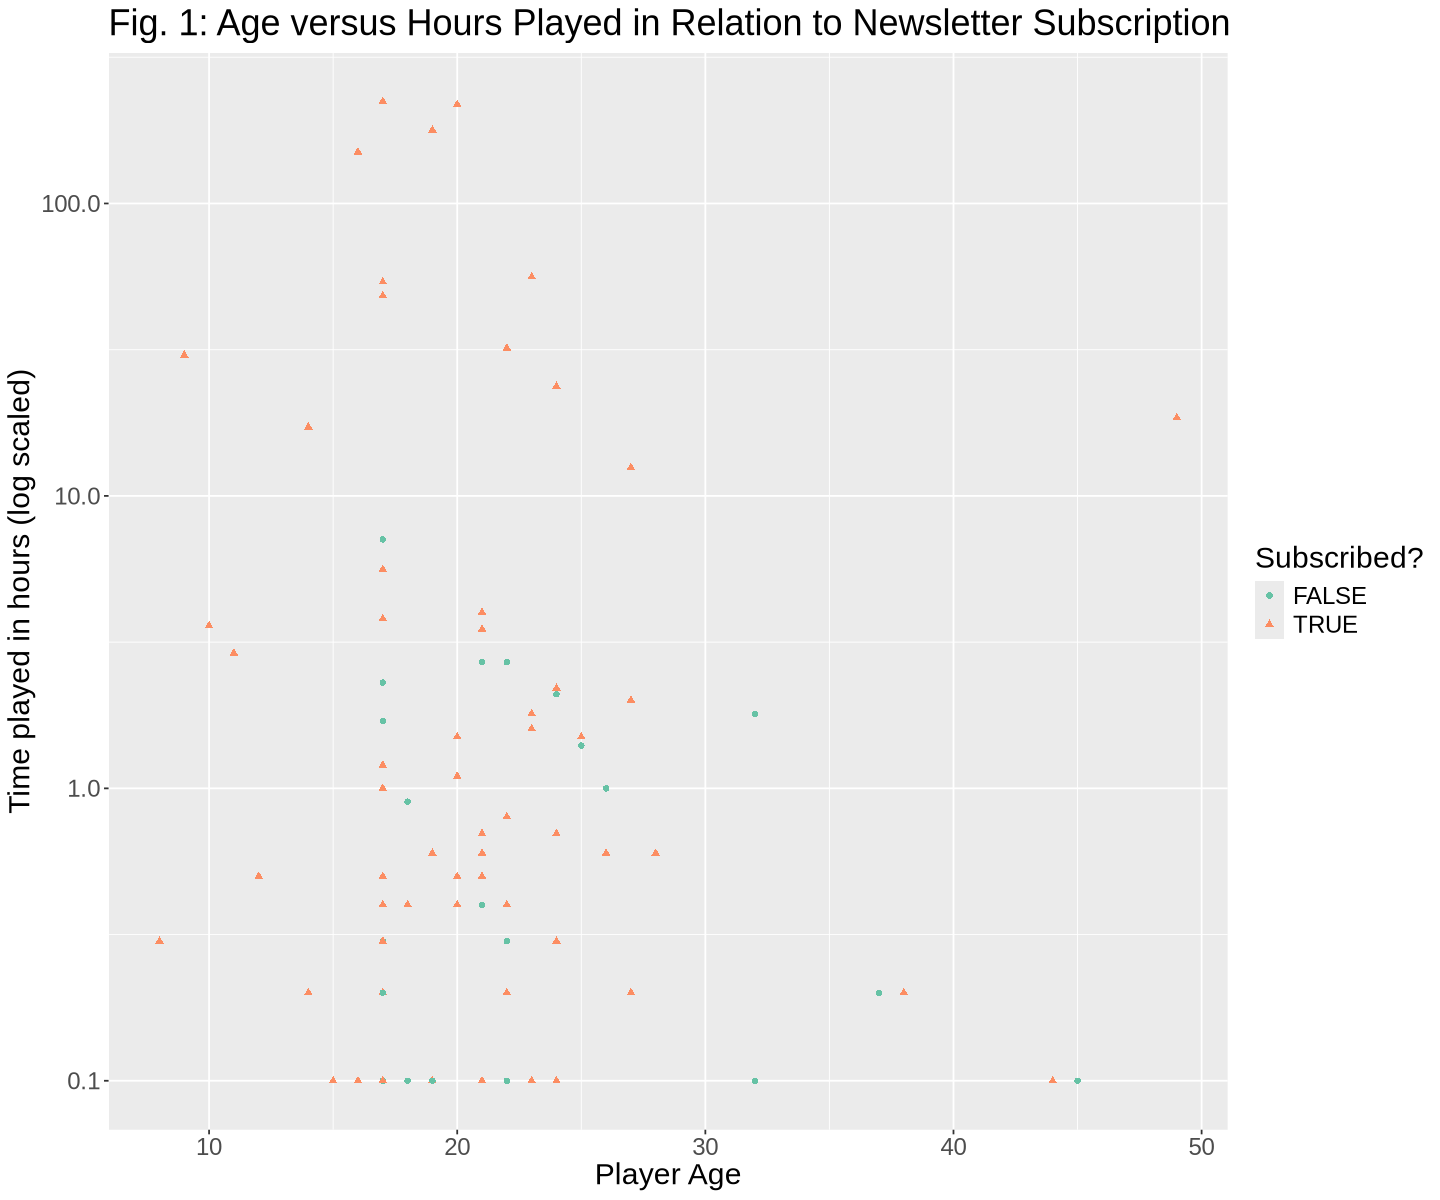

In [6]:
options(repr.plot.height = 10, repr.plot.width = 12)

players_plot <- players_tidy |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe, shape = subscribe)) +
    geom_point() +
    labs(x = "Player Age", y = "Time played in hours (log scaled)", title = "Fig. 1: Age versus Hours Played in Relation to Newsletter Subscription",
         color = "Subscribed?", shape = "Subscribed?") +
    theme(text = element_text(size = 18)) +
    scale_color_brewer(palette = "Set2") +
    scale_y_log10()

players_plot

In [4]:
set.seed(100)

player_split <- initial_split(players_tidy, prop = 0.75, strata = subscribe)
player_training <- training(player_split)
player_testing <- testing(player_split)

player_recipe <- recipe(subscribe ~ . , data = player_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

player_vfold <- vfold_cv(player_training, v = 5, strata = subscribe)

k_compare <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics()

k_choice <- k_compare |>
    filter(.metric == "accuracy") |>
    slice_max(mean, n = 1)

k_choice

# Choose 5 because it means there will be no ties

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,binary,0.7992157,5,0.03582176,Preprocessor1_Model05
6,accuracy,binary,0.7992157,5,0.03582176,Preprocessor1_Model06
